## When we make a prediction using a machine learning algorithm, there's an implicit understanding that we're not going to get it *exactly right* everytime.

There's lots of reasons why our predictions might be wrong - natural variation, 'hidden' variables that we're unable to measure, noisy/limited training data etc., but we need to have an understanding of *how wrong* we might be. For example, let's say we were developing an algorithm to identify the presence of a neurological condition from MRI scans and we wanted to predict the probability that a patient had the condition.

Suppose that we trained an algorithm to predict these probabilities and that for a given patient the result came back that there was a 10\% chance that they had the condition. Normally, we would most likely use that result to tell our patient that they were probably healthy. But what if we knew that our model wasn't particularly reliable and we knew that if it predicted a 10\% chance of having the condition, the **true** probability of having the disease was somewhere between 5\% and 60\%? Would we still feel confident using our model as the basis for a diagnosis or would we want to run further tests?

The above is an example of why it's important to be able to quantify the uncertainty in the predictions our models make. Bayesian approaches allow us to do this in a natural way without much additional computation. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate data 

In [2]:
n = 40 #Number of observations in the training set

targetPrecision = 30

X = np.random.uniform(-np.pi, np.pi, n)
Y = [np.sin(x) + np.random.normal(0, np.sqrt(1/targetPrecision)) for x in X]

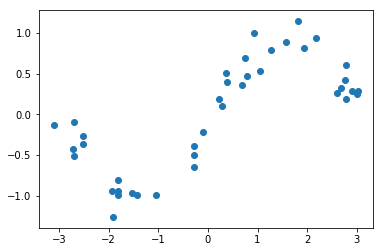

In [3]:
plt.scatter(X,Y)
plt.show()

Clearly the relationship above between the single feature and our target is non-linear - it would not be well-approximated by a function of the form $y(x) = \omega_0 + \omega_1 \times x$. Whilst this normally might make us consider an alternative model to linear regression (a Decision-Tree or Nearest-Neighbour based method, perhaps), by doing some preprocessing of our data, we can still use a linear regression model and obtain a reasonable fit to the data.

Depending on how familiar you are with polynomials, you might know that they can be powerful tools for curve fitting. We won't go into detail here but you can google 'Lagrange Polynomials' if you want to find out more. Briefly, we can use polynomial transformations to obtain a larger set of features; instead of each example having a single feature $x$, we can fit a model where each example has $p$ features $(x, x^2, x^3,...,x^p)$. Thus, instead of being constrained to fitting a model of the form:

$$y(x) = \omega_0 + \omega_1 \times x$$

We can fit a model of the form: 

$$y(x) = \omega_0 + \omega_1 \times x + \omega_2 \times x^2 + ... + \omega_p \times x^p$$

The larger number of parameters in the second model allows us to approximate more complex relationships between feature and target - indeed, in theory, if we have enough data then we can fit a model with any number of parameters. However, as always, increasing the number of model parameters induces the risk of overfitting the model, so we don't want to introduce to many extra variables to our model. In the model below we consider models of the form:

$$y(x) = \omega_0 + \omega_1 \times x + \omega_2 \times x^2 + \omega_3 \times x^3 + \omega_4 \times x^4$$

Now let's clarify some notation: For the remainder of this notebook we're going to use $\phi(x) := [1, x, x^2, x^3, x^4]$, i.e. $\phi(x_i)$ represents the model input for example $i$. Additionally, we define $\Phi$ = $[\phi(x_1),...,\phi(x_n)]^T$, the matrix of all the inputs. We use $\omega = [\omega_0, ..., \omega_4]^T$

# Generate Basis Functions

In [4]:
data = {'Y':Y}

def addBasisFunctions(data, X, n):
    for i in range(n):
        data[f'X{i}'] = [x**i for x in X]
    
    return pd.DataFrame(data)
    

data = addBasisFunctions(data, X, 5)

In [5]:
data.head() #We can see that the X0 values are always zero, corresponding to our intercept term

Y   X0        X1        X2         X3         X4
0  0.185135  1.0  0.214695  0.046094   0.009896   0.002125
1  0.533429  1.0  1.043660  1.089227   1.136783   1.186415
2  0.469698  1.0  0.791412  0.626333   0.495688   0.392293
3 -0.992075  1.0 -1.423908  2.027515  -2.886996   4.110818
4  0.328533  1.0  2.683233  7.199738  19.318572  51.836226

## Formulating the Bayesian Linear Regression Model

We start by using the standard expression for a linear regression model. For a dataset $D = \{(x_1, y_1), ..., (x_n, y_n)\}$, we assume that:

$$y_i | x_i, \omega \sim N(\omega^T\phi(x_i), \beta^{-1})$$

So the target is a linear combination of our basis vectors, with some noise added on. Note that when $\beta$ is large, our variance is small and vice versa (we call $\beta$ the 'precision' of our random variable.

Now, under standard linear regression, we imagine that $\omega$ is a a fixed, unknown vector and our task is to estimate values that get us as close to this unkwown value as possible. With Bayesian linear regression, we frame things slightly differently: Instead, we assume that $\omega$ is a **random variable** and we try to assign to it a probability distribution - this might sound like a small adjustment, but it's this that allows us to quantify the uncertainty in our predictions later on.

As with any Bayesian analysis, the first step is to specify our **prior distribution** for $\omega$. We haven't inspected the data yet and if we don't know a great deal about the subject matter so a reasonable thing to do is to choose our prior to be an isotropic gaussian - that is:

$$\omega \sim MVN(0, \alpha^{-1}I)$$

So our initial guess for the distribution is that the parameter values follow a multivariate normal distribution with 0 mean and a diagonal covariance matrix ($\alpha$ is a hyperparameter that we choose). This is often a reasonable assumption to make as adopting a non-zero parameter value assumes that there is some sort of relationship between feature and label (you can think about why this might bring the integrity of our results into question if we did this in, say, a clinical drug trial) and the isotropic gaussian prior also has the effect of acting as a regulariser on $\omega$ and helps to mitigate the effects of overfitting - if it's not immediately clear why that is the case you don't need to worry about it; it's far from essential in understanding how the method works! 

# The posterior predictive distribution

Now that we've specified our model, let's write down what we'd like to calculate: Given our training set $D$, if we're given a new example $x^*$, we'd like to be able to estimate the probability of the associated target, $y^*$, taking any given value is.

In other words, we want to calculate the probability distribution:

$$p(y^*| x^*, D)$$

To do this, we can note that: 

$$p(y^*| x^*, D) = \int p(y^*, \omega| x^*, D) d\omega = \int p(y^*|\omega, x^*) p(\omega | D) d\omega $$

So our probability distribution is the integral of the product of two probability distributions - although it might seem that this might make things more complicated, the model assumptions we made above simplifies things greatly. Let's focus on $p(w|D)$ first - this is the posterior distribution of $\omega$ given $D$. As we assumed the $\omega$ had a gaussian prior and the likelihood also followed a gaussian distribution, we get that the posterior also has a gaussian distribution. Bishop goes into much more detail in section 3.3.1 and elsewhere, but essentially calculating the posterior distribution is just a matter of updating the parameters of the multivariate distribution, so that:

$$\omega|D \sim MVN(\mu, \Sigma)$$

Where $\Sigma = (\alpha \times I + \beta \times \Phi^{T}\Phi)^{-1}$ and $\mu = \beta \times \Sigma\Phi^T[y_1,...,y_n]^T$

So the posterior variance is a tradeoff between the strength of the prior distribution and the amount of variation exhibited in the data. Similarly, the inclusion of $\Sigma$ in the expression for $\mu$ creates another tradeoff between the prior and the data - if $\alpha$ is very large then the posterior mean will be pushed towards zero, whereas if $\beta >> \alpha$ then the posterior mean will be much closer to the values derived using standard linear regression. 

A good exercise is to fully write out the expressions for the estimate of $\omega$ using standard linear regression and then the posterior distribution parameters (mean and variance) using the Bayesian approach and try to write down how then differ and how the various hyperparameters affect things as they vary.

Now that we've parameterised $p(\omega|D)$ we can obtain the parameters of the posterior predictive distribution (see Bishop section 3.3.2 for more details). We have:

$$p(y^*| x^*, D)  = \int p(y^*|\omega, x^*) p(\omega | D) d\omega = N(y^*|\mu^T\phi(x^*), \beta^{-1} + \phi(x^*)^T\Sigma\phi(x^*))$$


The above contains all we need to implement the Bayesian Linear Regression below. Typically when we're making predictions for a new example we return the posterior predictive mean and the associated variance, allowing us to compute a confidence interval for the label.

In [6]:
class BayesianLinearRegression:
    
    def __init__(self, data, target, features, targetPrecision, priorPrecision = 1, trainTestRatio = 0.9):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #features - A list containing the names of the columns which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        if trainTestRatio < 1:
            self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
        else:
            self.train = data #We intend to use this when we consider the impact of the training set size
                            #on the posterior distribution later. For any practical purpose we would usually set 
                            #trainTestRatio <1
    
        #Set precision (1/variance in the normal distribution) parameters
        #targetPrecision is a measure of the fluctuation in the target - for example if we had 
            #1000 examples with the exact same feature, how much variation would we see between the 
            #target variables - this value can be estimated from the data, but for simplicity here we
            #take the value we used when assigning noise when generating the data
        #priorPrecision is the precision parameter for our prior distribution - it's a hyperparameter that it's 
            #up to us to specify and tune.
        self.targetPrecision = targetPrecision #beta in the text above
        self.priorPrecision = priorPrecision #alpha in the text above
        
        self.Phi = self.train[self.features].to_numpy() #Convert input dataframe to numpy array so we can do matrix algebra on it
        self.y = self.train[self.target].to_numpy()
        
    def calculatePosterior(self):
        #Given the data and prior distribution parameters, calculate the posterior distribution for the weights
        
        #As we have a normal prior for the weights, and a normal likelihood, calculating the posterior is simply a
        #matter of updating the weights of the normal distribution
        
        #We have to compute the posterior variance first, because it's used in the calculation of the posterior mean
        #The posterior variance is a covariance matrix, as opposed to a single number - it's dimensions are p*p where
        #p is the number of basis functions we've used        
        self.postVar = np.linalg.inv(self.priorPrecision*np.identity(len(self.features)) + self.targetPrecision*np.matmul(np.transpose(self.Phi), self.Phi))
        self.postMean = self.targetPrecision*np.matmul(self.postVar, np.matmul(np.transpose(self.Phi), self.y))
    
    
    def makePredictionWithVarianceSingle(self, phi):
        #phi is the set of basis functions applied to a single input vector x
        
        predMean = np.dot(phi, self.postMean)
        predVar = 1/self.targetPrecision + np.dot(phi, np.matmul(self.postVar, phi))
        
        return predMean, predVar
    
    def makePredictionsWithVariance(self, PhiNew):
        #Make predictions for a dataset of inputs
        #PhiNew is a pandas dataframe, where each row corresponds to the basis functions applied to a single example
        
        predMeans = []
        predVars = []
        
        for idx, row in PhiNew.iterrows():
            pm, pv = self.makePredictionWithVarianceSingle(row)
            
            predMeans.append(pm)
            predVars.append(pv)
        
        return predMeans, predVars
            

In [7]:
myBLR = BayesianLinearRegression(data, 'Y', [f'X{i}' for i in range(5)], targetPrecision=targetPrecision, priorPrecision=1, trainTestRatio=0.8)

In [8]:
myBLR.calculatePosterior()

In [9]:
testMean, testVar = myBLR.makePredictionsWithVariance(myBLR.test[myBLR.features])
myBLR.test['predMean'] = testMean
myBLR.test['predVar'] = testVar
myBLR.test = myBLR.test.sort_values(by = 'X1', ascending = True)

/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


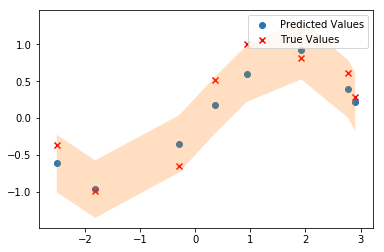

In [10]:
plt.scatter(myBLR.test['X1'], myBLR.test['predMean'], label = 'Predicted Values')
plt.scatter(myBLR.test['X1'], myBLR.test[[myBLR.target]], marker = "x", color = 'red', label = 'True Values')
plt.fill_between(myBLR.test['X1'], myBLR.test['predMean'] - 2*np.sqrt(myBLR.test['predVar']), myBLR.test['predMean'] + 2*np.sqrt(myBLR.test['predVar']), alpha = 0.25)

plt.legend()
plt.show()

# Now lets fit the model with a much smaller dataset and observe the effect on the variance

In [11]:
#Set train test split to be smaller so our training set is smaller
myBLRSmall = BayesianLinearRegression(data, 'Y', [f'X{i}' for i in range(5)], targetPrecision=targetPrecision, priorPrecision=1, trainTestRatio=0.3)
myBLRSmall.calculatePosterior()

In [12]:
Xreg = np.arange(-np.pi, np.pi, step = 0.01)
#Get basis functions
phi = addBasisFunctions({}, Xreg, 5)

In [13]:
meanBig, varBig = myBLR.makePredictionsWithVariance(phi)
meanSmall, varSmall = myBLRSmall.makePredictionsWithVariance(phi)

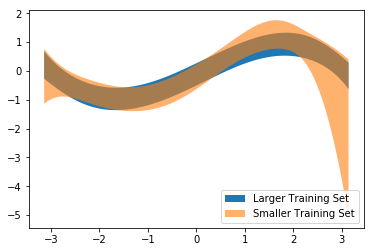

In [14]:
plt.fill_between(Xreg, meanBig - 2*np.sqrt(varBig), meanBig + 2*np.sqrt(varBig), alpha = 1, label = 'Larger Training Set')
plt.fill_between(Xreg, meanSmall - 2*np.sqrt(varSmall), meanSmall + 2*np.sqrt(varSmall), alpha = 0.6, label = 'Smaller Training Set')

plt.legend(loc = 4)
plt.show()

We can see that the variance in the model trained with the smaller training set provides greater uncertainty in its predictions. The smaller the coloured region, the greater the confidence we have in our predictions.

# Visualising the distributions over functions

Lots of the literature surrounding Bayesian regression talks about a distribution *over functions*. This can be very difficult for us to understand as we're used to thinking about distributions over continuous (e.g. the normal distribution) or discrete (e.g. the binomial distribution) sets of numbers.

When we specify our prior distribution over the weights of a model, which we need to do to fit the Bayesian linear regression model, we're specifying a multivariate normal distribution. Under this set-up, each possible combination of weights comes with an associated probability. Consider the following example: If we're trying to fit a model of the form $y = w_0 + w_1 \times x$ (and therefore trying to find the optimal set of weights $(w_0, w_1)$), and we specify a prior for $$\begin{pmatrix} w_0 \\ w_1 \end{pmatrix} \sim N \Bigg(\begin{pmatrix} 0 \\ 0 \end{pmatrix} , \begin{pmatrix} \alpha_1 & 0 \\ 0 & \alpha_2 \end{pmatrix} \Bigg)$$

Under this prior distribution, we can verify that the pair of weights $(1,2)$ is more likely than the pair of weights $(75, 100)$ - this is because the closer a pair of weights is to the mean of our prior distribution, the more likely it is.

But under the model assumption that we made, a pair of weights uniquely corresponds to a function - we can therefore say that the function $y = 1 + 2 \times x$ is more likely than $y = 75 + 100 \times x$, because both of these functions corresponds uniquely to a pair of weights and we have a well-defined distribution which tells us how likely a pair of weights is.

This weights-to-function relationship allows us to think about a distribution over functions. As we fit the Bayesian regression model, we obtain a posterior distribution over the weights and therefore a new distribution over functions too.

To gain some intuition for these distributions, lets sample some functions from them and plot them

## Sampling from the prior distribution

For the models we've fit above, the prior weights distribution we specified was: $w \sim N(0, I_5)$, lets sample 50 sets of weights from that distribution:

In [15]:
priorWeights = np.random.multivariate_normal(mean = np.zeros(5), cov = np.identity(5), size = 50)

In [16]:
#Convert weights to functions
priorFunctions = []
for w in priorWeights:
    priorFunctions.append(np.dot(w, np.transpose(phi.to_numpy())))
    
priorFunctions = np.array(priorFunctions)

(-10, 10)

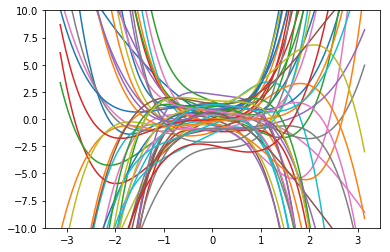

In [17]:
for f in priorFunctions:
    plt.plot(Xreg, f)

plt.ylim((-10,10))

We can see that the functions sampled from the prior don't fit the dataset we're trying to fit our model to at all - that's ok! There's no real reason we'd expect it to, since we selected a 'non-informative' prior

## Sampling from the posterior distribution 

In [18]:
posteriorWeights = np.random.multivariate_normal(mean = myBLR.postMean, cov = myBLR.postVar, size = 50)

In [19]:
postFunctions = []
for w in posteriorWeights:
    postFunctions.append(np.dot(w, np.transpose(phi.to_numpy())))
    
postFunctions = np.array(postFunctions)

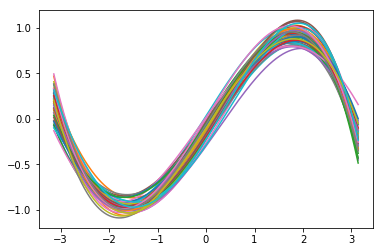

In [20]:
for f in postFunctions:
    plt.plot(Xreg, f)

These functions, sampled from our posterior distribution on functions, much more closely resembles the dataset. In fact, with all the functions laid on top of each other, the area they occupy resembles the confidence interval we plotted above. This is not a coincidence, at each point on the x axis the 95% confidence interval we plotted is a region such that if we sampled a random function from the posterior, then 95% of the time, that function would be within the confidence interval at a specific x-value

## To get an intermediate view on the distribution over functions, let's see how the posterior changes as we add more points to the training set

In [21]:
def varyTrainingSize(data, phi):
    
    #data is our training set
    #phi is the value of our basis functions along a mesh of the x-axis
    
    plotStore = []
    
    for size in list(range(1, 10)) + [int(data.shape[0]/3), int(data.shape[0]/2), int(data.shape[0])]:
        #Train on 1,2,3,...,9 points, 1/3, 1/2 and all of the available data
        
        d = data.head(size)
        myBLR = BayesianLinearRegression(d, 'Y', [f'X{i}' for i in range(5)], targetPrecision=targetPrecision, priorPrecision=1, trainTestRatio=1)
        myBLR.calculatePosterior()
        
        #Sample Posterior weights
        posteriorWeights = np.random.multivariate_normal(mean = myBLR.postMean, cov = myBLR.postVar, size = 50)
        
        #Obtain posterior functions
        postFunctions = []
        for w in posteriorWeights:
            postFunctions.append(np.dot(w, np.transpose(phi.to_numpy())))

        postFunctions = np.array(postFunctions)
        
        #Create figure
        fig = plt.figure(figsize = (10,6))
        
        plt.scatter(myBLR.train['X1'], myBLR.train['Y'], color = 'black', s = 150, figure=fig)

        for f in postFunctions:
            plt.plot(Xreg, f, alpha = 0.2, figure=fig)

        plt.ylim((-3,3))
        
        plotStore.append(fig)
        
        #Output plots of posterior samples
    return plotStore
        


        

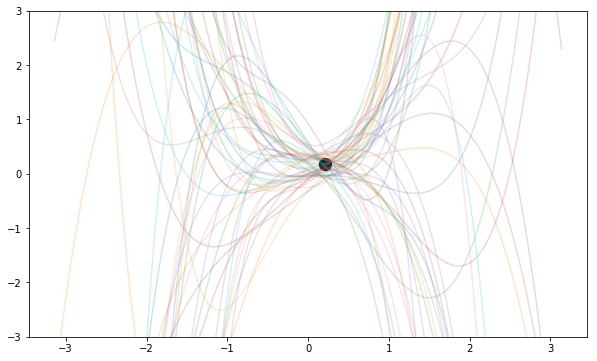

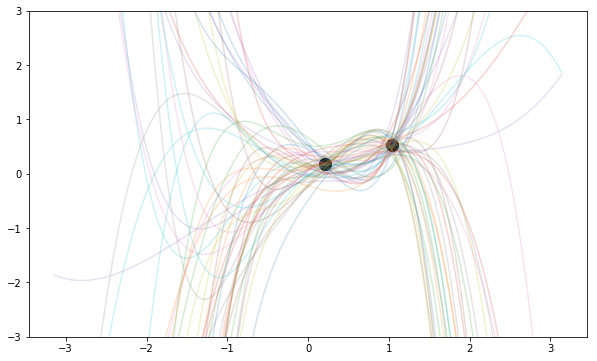

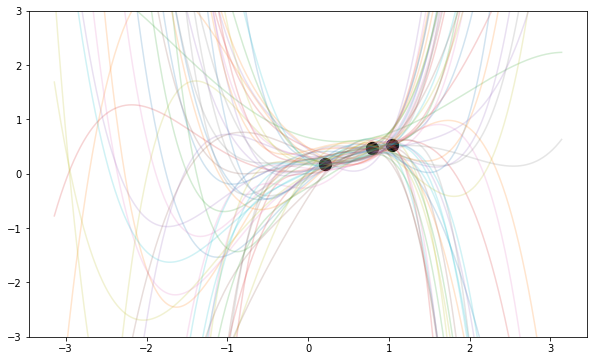

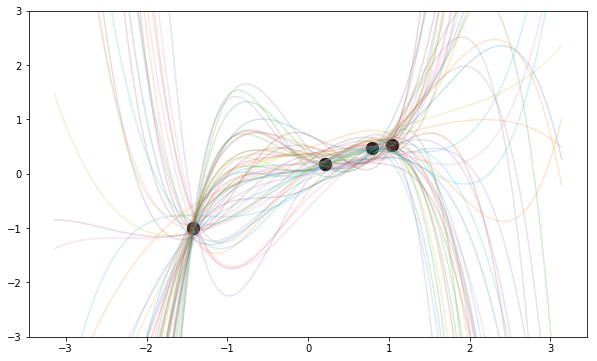

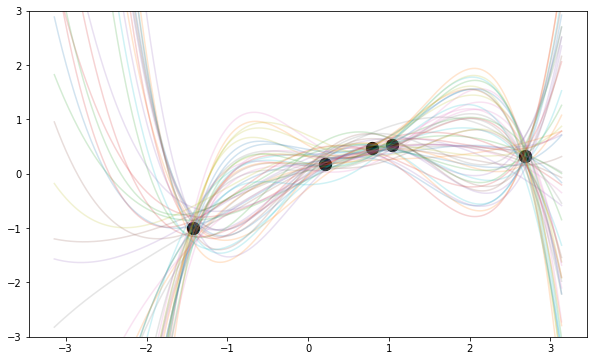

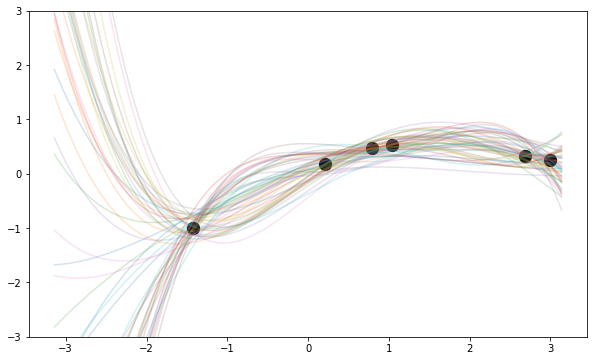

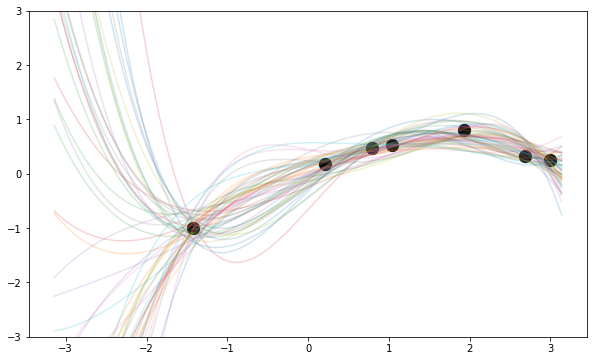

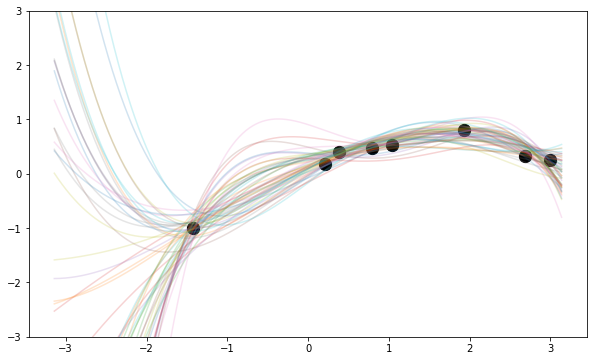

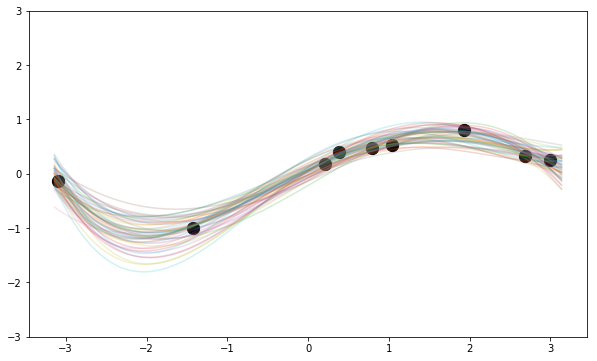

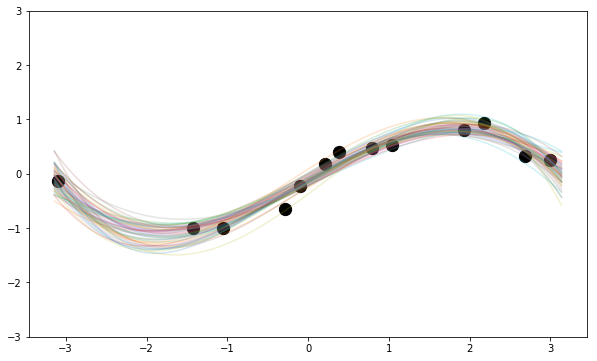

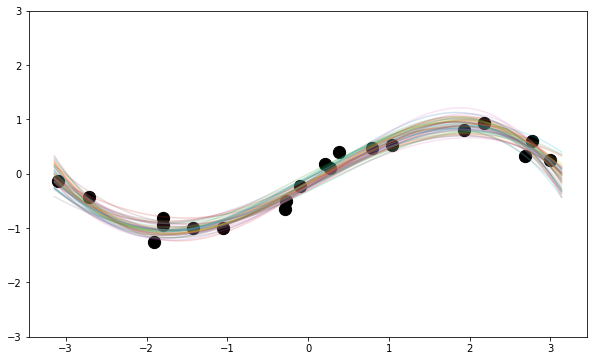

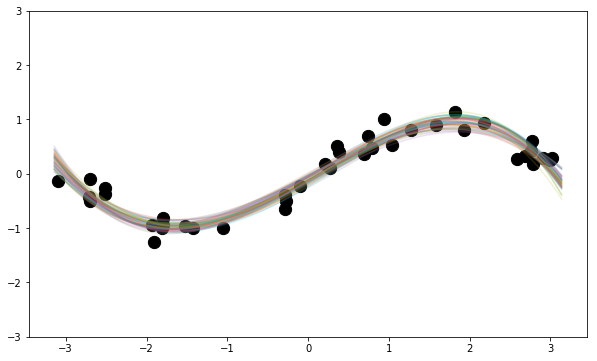

In [22]:
plots = varyTrainingSize(data, phi)

If we inspect the posterior samples for the models trained on one or two examples, we can see that they exhibit a tremendous amount of variance, except in the regions close to one of the training points. This is very desirable behaviour - if we don't have anything in our training set that resembles the point we are seeking to evaluate, we should treat the predictions with a high degree of skepticism.

As we train the model with a larger number of data points, we can see that our model is able to accurately learn the relationship between feature and target, and the disparity between different curves from the posterior distribution shrinks



## If you want to make a little video of the how the posterior distribution changes as you increase the size of your training set, you can adapt the code below!

In [23]:
myFolder = '/Users/tom/Documents' #Change folder to your directory
for idx, p in enumerate(plots):
    p.savefig(f'{myFolder}/BLR{idx}.png') 

In [24]:
import cv2
img_array = []
numFramesPerSec = 3

for idx in range(len(plots)):
    filename = f'/Users/tom/Documents/BLR{idx}.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter(f'{myFolder}/functionSpace.mp4',cv2.VideoWriter_fourcc(*'DIVX'), numFramesPerSec, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()